A demo training script for training the H-network.

Grab the dataset first

We create a dataset, in which the user's load $y_t$ is loaded from the split aggregate_df dataset  
Then we generate the load received from the grid $z_t$ as a function of $y_t$ and random Gaussian noise $b$ (to represent the battery charging/discharging rate), i.e. $z_t = y_t + b, \quad b \sim \mathcal{N}(0, I)$

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
aggregate_load_segments, aggregate_load_df = load_split_data_from_folder(dataset_folder_path, 'train')

In [6]:
aggregate_load_df

,timestamp,aggregate,datetime,washing_machine,dishwasher,fridge,kettle,microwave,toaster,tv,htpc,gas_oven,kitchen_lights
0,1.357603e+09,234.0,2013-01-08 00:00:05+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,69.0,NaN,0.0
1,1.357603e+09,231.0,2013-01-08 00:00:11+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,70.0,NaN,0.0
2,1.357603e+09,234.0,2013-01-08 00:00:17+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,70.0,NaN,0.0
3,1.357603e+09,232.0,2013-01-08 00:00:23+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,68.0,NaN,0.0
4,1.357603e+09,232.0,2013-01-08 00:00:30+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,70.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231636,1.388448e+09,178.0,2013-12-30 23:59:35+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2231637,1.388448e+09,177.0,2013-12-30 23:59:41+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2231638,1.388448e+09,178.0,2013-12-30 23:59:47+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
2231639,1.388448e+09,178.0,2013-12-30 23:59:53+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0


In [7]:
aggregate_load_segments

[(datetime.datetime(2013, 1, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 2, 27, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 28, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 31, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 22, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 26, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 4, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 4, 10, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 4, 26, 0, 0, tzinfo=datetime.timezone.utc),
  d

In [8]:
# break the segments into per-day segments
def break_segments_into_days(segments):
    """Break segments into per-day segments"""
    daily_segments = []
    for start, end in segments:
        current = start
        while current < end:
            next_day = current + timedelta(days=1) - timedelta(milliseconds=1)
            daily_segments.append((current, min(next_day, end)))
            current = next_day + timedelta(milliseconds=1)
    return daily_segments

daily_segments = break_segments_into_days(aggregate_load_segments)

daily_segments

[(datetime.datetime(2013, 1, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 9, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 1, 10, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 2, 27, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 2, 27, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 2, 28, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 8, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2013, 3, 8, 23, 59, 59, 999000, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2013, 3, 9, 0, 0, tzinfo=datetime.timezone.utc),
  datet

In [9]:
# extract the daily aggregate load data from the dataframe
def create_24_hour_sequences(aggregate_load_df, segments):
    """Create 24-hour sequences from aggregate load data"""
    sequences = []
    for start, end in segments:
        day_data = aggregate_load_df[(aggregate_load_df['datetime'] >= start) & (aggregate_load_df['datetime'] <= end)]

        # only keep the timestamp, aggregate, datetime columns
        day_data = day_data[['timestamp', 'aggregate', 'datetime']]

        if not day_data.empty:
            sequences.append(day_data)
    return sequences

daily_sequences = create_24_hour_sequences(aggregate_load_df, daily_segments)

In [10]:
# for each daily sequence, comnpute the load received from the grid
np.random.seed(20250706)  # for reproducibility

def compute_load_received_from_grid(daily_sequences, noise_std=0.1):
    """Compute load received from the grid for each daily sequence"""
    grid_loads = []
    for seq in daily_sequences:
        # generate random noise
        noise = np.random.normal(0, noise_std, len(seq))
        # compute load received from the grid

        grid_load = seq['aggregate'] + noise
        # ensure non-negative grid load
        seq['grid_load'] = grid_load.clip(lower=0)
        grid_loads.append(seq)
    return grid_loads

daily_sequences = compute_load_received_from_grid(daily_sequences)

Construct input and (targetted) output of the H-network

Input:  
For each episode:  
Input sequence: $( [y_0, y_1, ..., y_{T-1}], [z_0, z_1, ..., z_{T-1}] )$ (possibly concatenated per time step)  
Target:  
For each episode:  
Target sequence: $( [y_1, y_2, ..., y_T] )$ (the next-step user load at each time step)  

In [11]:
daily_sequences[1]

,timestamp,aggregate,datetime,grid_load
13380,1.357690e+09,179.0,2013-01-09 00:00:04+00:00,178.859698
13381,1.357690e+09,176.0,2013-01-09 00:00:10+00:00,176.039983
13382,1.357690e+09,177.0,2013-01-09 00:00:16+00:00,177.079653
13383,1.357690e+09,175.0,2013-01-09 00:00:23+00:00,174.779029
13384,1.357690e+09,177.0,2013-01-09 00:00:29+00:00,176.862363
...,...,...,...,...
26758,1.357776e+09,311.0,2013-01-09 23:59:25+00:00,310.821487
26759,1.357776e+09,305.0,2013-01-09 23:59:37+00:00,304.975486
26760,1.357776e+09,310.0,2013-01-09 23:59:43+00:00,310.001421
26761,1.357776e+09,309.0,2013-01-09 23:59:49+00:00,309.034510


In [12]:
# compute mean length of the sequences
mean_length = np.mean([len(seq) for seq in daily_sequences])
mean_length

13775.561728395061

Perform data preprocessing (standardization & normalization) for each daily sequence  
before creating input & target sequences for the H-network

In [13]:
# perform data preprocessing (standardization)
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()

scaler_train = scaler_train.fit(aggregate_load_df[['aggregate']].values)

def preprocess_daily_sequences(daily_sequences, scaler):
    """Preprocess daily sequences using the provided scaler"""
    for seq in daily_sequences:
        # standardize the aggregate load
        seq['aggregate'] = scaler.transform(seq[['aggregate']].values)

        seq['grid_load'] = scaler.transform(seq[['grid_load']].values)

preprocess_daily_sequences(daily_sequences, scaler_train)

In [14]:
daily_sequences[1]

,timestamp,aggregate,datetime,grid_load
13380,1.357690e+09,-0.403357,2013-01-09 00:00:04+00:00,-0.403714
13381,1.357690e+09,-0.410987,2013-01-09 00:00:10+00:00,-0.410886
13382,1.357690e+09,-0.408444,2013-01-09 00:00:16+00:00,-0.408241
13383,1.357690e+09,-0.413531,2013-01-09 00:00:23+00:00,-0.414093
13384,1.357690e+09,-0.408444,2013-01-09 00:00:29+00:00,-0.408794
...,...,...,...,...
26758,1.357776e+09,-0.067634,2013-01-09 23:59:25+00:00,-0.068088
26759,1.357776e+09,-0.082894,2013-01-09 23:59:37+00:00,-0.082957
26760,1.357776e+09,-0.070177,2013-01-09 23:59:43+00:00,-0.070174
26761,1.357776e+09,-0.072721,2013-01-09 23:59:49+00:00,-0.072633


In [16]:
print('after standardization')
print("min aggregate load:", np.min(np.concatenate([seq['aggregate'] for seq in daily_sequences])))
print("max aggregate load:", np.max(np.concatenate([seq['aggregate'] for seq in daily_sequences])))
print("-" * 30)
print("min grid load:", np.min(np.concatenate([seq['grid_load'] for seq in daily_sequences])))
print("max grid load:", np.max(np.concatenate([seq['grid_load'] for seq in daily_sequences])))

after standardization
min aggregate load: -0.6653229366830373
max aggregate load: 16.069966006728873
------------------------------
min grid load: -0.6651885384298
max grid load: 16.070132690819786


In [15]:
# create input and target sequences for the H-network
def create_h_network_sequences(daily_sequences):
    """Create input and target sequences for the H-network"""
    input_sequences = []
    target_sequences = []
    
    for seq in daily_sequences:
        # input sequence: [z_0, z_1, ..., z_{T-1}], [y_0, y_1, ..., y_{T-1}]
        input_seq = np.column_stack((seq['grid_load'].values[:-1], seq['aggregate'].values[:-1]))
        
        # target sequence: [y_1, y_2, ..., y_T]
        target_seq = seq['aggregate'].values[1:]
        
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
    
    return list(input_sequences), list(target_sequences)        # since each seq has different length, we return lists instead of numpy arrays

input_sequences, target_sequences = create_h_network_sequences(daily_sequences)

Compute padding & masking, and chunking the sequence into 512 length.

Chunk the sequence using sparse-separated rolling windows, e.g. with stride = 512/8 = 64

In [16]:
import torch

def chunk_pad_mask_sequences(input_sequences, target_sequences, chunk_size=512, stride=64, padding_value=0.0):
    """
    Chunk, pad, and mask input/target sequences for LSTM training.
    Args:
        input_sequences: list of np.ndarray, each shape (T, 2)
        target_sequences: list of np.ndarray, each shape (T,)
        chunk_size: int, length of each chunk
        stride: int, step size for rolling window
        padding_value: value to use for padding
    Returns:
        padded_inputs: torch.Tensor, shape (N, chunk_size, 2)
        padded_targets: torch.Tensor, shape (N, chunk_size)
        mask: torch.BoolTensor, shape (N, chunk_size)
    """
    chunked_inputs = []
    chunked_targets = []
    chunked_masks = []

    for inp_seq, tgt_seq in zip(input_sequences, target_sequences):
        seq_len = inp_seq.shape[0]
        # Rolling window chunking
        for start in range(0, seq_len, stride):
            end = start + chunk_size
            inp_chunk = inp_seq[start:end]
            tgt_chunk = tgt_seq[start:end]
            mask = np.zeros(chunk_size, dtype=bool)
            valid_len = min(chunk_size, seq_len - start)
            mask[:valid_len] = True
            # Pad if needed
            if inp_chunk.shape[0] < chunk_size:
                pad_len = chunk_size - inp_chunk.shape[0]
                inp_chunk = np.pad(inp_chunk, ((0, pad_len), (0, 0)), mode='constant', constant_values=padding_value)
                tgt_chunk = np.pad(tgt_chunk, (0, pad_len), mode='constant', constant_values=padding_value)
            chunked_inputs.append(torch.tensor(inp_chunk, dtype=torch.float32))
            chunked_targets.append(torch.tensor(tgt_chunk, dtype=torch.float32))
            chunked_masks.append(torch.tensor(mask, dtype=torch.bool))
            # Stop if we've reached the end
            if end >= seq_len:
                break

    padded_inputs = torch.stack(chunked_inputs)
    padded_targets = torch.stack(chunked_targets)
    mask = torch.stack(chunked_masks)
    return padded_inputs, padded_targets, mask

# Example usage:
padded_inputs, padded_targets, mask = chunk_pad_mask_sequences(input_sequences, target_sequences, chunk_size=512, stride=64)
print(f"padded_inputs shape: {padded_inputs.shape}")
print(f"padded_targets shape: {padded_targets.shape}")
print(f"mask shape: {mask.shape}")

padded_inputs shape: torch.Size([33817, 512, 2])
padded_targets shape: torch.Size([33817, 512])
mask shape: torch.Size([33817, 512])


Perform the same data processing for test dataset and validation dataset

In [17]:
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test')
daily_segments_test = break_segments_into_days(aggregate_load_segments_test)
daily_sequences_test = create_24_hour_sequences(aggregate_load_df_test, daily_segments_test)
daily_sequences_test = compute_load_received_from_grid(daily_sequences_test)
daily_segments_test = preprocess_daily_sequences(daily_sequences_test, scaler_train)
input_sequences_test, target_sequences_test = create_h_network_sequences(daily_sequences_test)
padded_inputs_test, padded_targets_test, mask_test = chunk_pad_mask_sequences(input_sequences_test, target_sequences_test, chunk_size=512, stride=128)
print(f"padded_inputs_test shape: {padded_inputs_test.shape}")
print(f"padded_targets_test shape: {padded_targets_test.shape}")
print(f"mask_test shape: {mask_test.shape}")

padded_inputs_test shape: torch.Size([8396, 512, 2])
padded_targets_test shape: torch.Size([8396, 512])
mask_test shape: torch.Size([8396, 512])


In [18]:
aggregate_load_segments_valid, aggregate_load_df_valid = load_split_data_from_folder(dataset_folder_path, 'val')
daily_segments_valid = break_segments_into_days(aggregate_load_segments_valid)
daily_sequences_valid = create_24_hour_sequences(aggregate_load_df_valid, daily_segments_valid)
daily_sequences_valid = compute_load_received_from_grid(daily_sequences_valid)
daily_segments_valid = preprocess_daily_sequences(daily_sequences_valid, scaler_train)
input_sequences_valid, target_sequences_valid = create_h_network_sequences(daily_sequences_valid)
padded_inputs_valid, padded_targets_valid, mask_valid = chunk_pad_mask_sequences(input_sequences_valid, target_sequences_valid, chunk_size=512, stride=128)
print(f"padded_inputs_valid shape: {padded_inputs_valid.shape}")
print(f"padded_targets_valid shape: {padded_targets_valid.shape}")
print(f"mask_valid shape: {mask_valid.shape}")

padded_inputs_valid shape: torch.Size([7615, 512, 2])
padded_targets_valid shape: torch.Size([7615, 512])
mask_valid shape: torch.Size([7615, 512])


Initialize the H-network model

In [19]:
from model.H_network.h_network import HNetwork
import torchinfo

# Initialize the H-network model
h_network = HNetwork(input_dim=2, hidden_dim=44, output_dim=1)

# Print model summary
torchinfo.summary(h_network, input_data=padded_inputs[:1], col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
HNetwork (HNetwork)                      [1, 512, 2]          [1, 512]             --                   True
├─LSTM (LSTM_1)                          [1, 512, 2]          [1, 512, 88]         16,896               True
├─Tanh (ac1)                             [1, 512, 88]         [1, 512, 88]         --                   --
├─LSTM (LSTM_2)                          [1, 512, 88]         [1, 512, 88]         47,168               True
├─Tanh (ac2)                             [1, 512, 88]         [1, 512, 88]         --                   --
├─Linear (fc)                            [1, 512, 88]         [1, 512, 1]          89                   True
Total params: 64,153
Trainable params: 64,153
Non-trainable params: 0
Total mult-adds (M): 32.80
Input size (MB): 138.51
Forward/backward pass size (MB): 0.72
Params size (MB): 0.26
Estimated Total Size (MB): 139.50

Create dataloader for training from the processed sequences

In [20]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(padded_inputs, padded_targets, mask)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create dataloader for validation
valid_dataset = TensorDataset(padded_inputs_valid, padded_targets_valid, mask_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Create dataloader for test
test_dataset = TensorDataset(padded_inputs_test, padded_targets_test, mask_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Declare loss function and optimizer

In [21]:
import torch.nn as nn

# Declare loss function and optimizer
# loss function is cross-entropy loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.GaussianNLLLoss()  # using Gaussian NLL loss for mean and log_variance outputs
optimizer = torch.optim.Adam(h_network.parameters(), lr=0.001)      # use Adam instead of RMSProp for better convergence

In [22]:
from model.early_stopper import EarlyStopper

# Initialize early stopper
early_stopper = EarlyStopper(patience=5, verbose=True, delta=0.001)

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

h_network.to(DEVICE)

HNetwork(
  (LSTM_1): LSTM(2, 44, batch_first=True, bidirectional=True)
  (ac1): Tanh()
  (LSTM_2): LSTM(88, 44, batch_first=True, bidirectional=True)
  (ac2): Tanh()
  (fc): Linear(in_features=88, out_features=1, bias=True)
)

In [24]:
from utils import print_log
from tqdm import tqdm

# training loop
target_num_epochs = 20
executed_epochs = 0

train_loss_list = []
valid_loss_list = []

for epoch in range(target_num_epochs):

    avg_train_loss = 0.0
    h_network.train()  # set the model to training mode

    # training loop
    with tqdm(train_dataloader, desc=f"Training Epoch [{epoch+1}/{target_num_epochs}]") as tepoch:
        for batch in tepoch:
            inputs, targets, mask = batch
            inputs, targets, mask = inputs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
            mean, lstm_1_h, lstm_2_h = h_network(inputs)  # get the mean, has shape (batch_size, chunk_size)

            # # apply mask to the mean and targets
            # mask_idx = -1
            # if not torch.all(mask):


            #     # find which row does not have all True values
            #     for i in range(mask.shape[0]):
            #         if not mask[i].all():
            #             print_log(f"Masking row {i} in batch {epoch+1}")

            #             print_log(f"mean before masking: {mean[i]}")
            #             print_log(f"targets before masking: {targets[i]}")
            #             print_log(f"mask: {mask[i]}")

            #             mask_idx = i
            #             break

            # we flatten the mean and targets to apply mask

            mean = mean.view(-1)
            targets = targets.view(-1)
            mask = mask.view(-1)

            mean_masked = torch.masked_select(mean, mask)  # apply mask to the mean
            targets_masked = torch.masked_select(targets, mask)  # apply mask to the targets

            loss = criterion(mean_masked, targets_masked, var=torch.ones_like(mean_masked))  # assuming unit variance for simplicity
            loss.backward()
            optimizer.step()

            if DEVICE.type == 'cuda':
                loss = loss.cpu()
            avg_train_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())
    
    
    avg_train_loss /= len(train_dataloader)
    train_loss_list.append(avg_train_loss)

    print_log(f"Epoch [{epoch+1}/{target_num_epochs}], Avg Loss: {avg_train_loss:.4f}")

    avg_valid_loss = 0.0
    h_network.eval()  # set the model to evaluation mode
    # validation loop
    with torch.no_grad():

        with tqdm(valid_dataloader, desc=f"Validating Epoch [{epoch+1}/{target_num_epochs}]") as vepoch:
            for batch in vepoch:
                inputs, targets, mask = batch
                inputs, targets, mask = inputs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE)
                mean, lstm_1_h, lstm_2_h = h_network(inputs)

                # flatten the mean and targets to apply mask
                mean = mean.view(-1)
                targets = targets.view(-1)
                mask = mask.view(-1)

                mean_masked = torch.masked_select(mean, mask)  # apply mask to the mean
                targets_masked = torch.masked_select(targets, mask)  # apply mask to the targets

                loss = criterion(mean_masked, targets_masked, var=torch.ones_like(mean_masked))  # assuming unit variance for simplicity

                if DEVICE.type == 'cuda':
                    loss = loss.cpu()
                avg_valid_loss += loss.item()

                vepoch.set_postfix(loss=loss.item())

    avg_valid_loss /= len(valid_dataloader)
    valid_loss_list.append(avg_valid_loss)

    print_log(f"Epoch [{epoch+1}/{target_num_epochs}], Avg Validation Loss: {avg_valid_loss:.4f}")

    executed_epochs = epoch + 1

    # early stopping check
    early_stopper(avg_valid_loss, h_network)
    if early_stopper.early_stop:
        print_log("Early stopping triggered. Stopping training.")
        break

Training Epoch [1/20]: 100%|██████████| 529/529 [00:02<00:00, 186.26it/s, loss=0.000407]


[2025-07-13 18:27:51:456] Epoch [1/20], Avg Loss: 0.0325


Validating Epoch [1/20]: 100%|██████████| 119/119 [00:00<00:00, 318.86it/s, loss=0.00307] 


[2025-07-13 18:27:51:831] Epoch [1/20], Avg Validation Loss: 0.0011
Validation loss decreased (inf --> 0.001071).  Saving model ...


Training Epoch [2/20]: 100%|██████████| 529/529 [00:03<00:00, 163.05it/s, loss=0.000444]


[2025-07-13 18:27:55:077] Epoch [2/20], Avg Loss: 0.0007


Validating Epoch [2/20]: 100%|██████████| 119/119 [00:00<00:00, 345.64it/s, loss=0.000965]


[2025-07-13 18:27:55:424] Epoch [2/20], Avg Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5


Training Epoch [3/20]: 100%|██████████| 529/529 [00:03<00:00, 167.68it/s, loss=6.02e-5] 


[2025-07-13 18:27:58:580] Epoch [3/20], Avg Loss: 0.0004


Validating Epoch [3/20]: 100%|██████████| 119/119 [00:00<00:00, 339.75it/s, loss=0.000665]


[2025-07-13 18:27:58:932] Epoch [3/20], Avg Validation Loss: 0.0003
EarlyStopping counter: 2 out of 5


Training Epoch [4/20]: 100%|██████████| 529/529 [00:03<00:00, 171.72it/s, loss=3.48e-5] 


[2025-07-13 18:28:02:014] Epoch [4/20], Avg Loss: 0.0004


Validating Epoch [4/20]: 100%|██████████| 119/119 [00:00<00:00, 339.06it/s, loss=0.000499]


[2025-07-13 18:28:02:367] Epoch [4/20], Avg Validation Loss: 0.0002
EarlyStopping counter: 3 out of 5


Training Epoch [5/20]: 100%|██████████| 529/529 [00:03<00:00, 175.66it/s, loss=8.69e-5] 


[2025-07-13 18:28:05:380] Epoch [5/20], Avg Loss: 0.0002


Validating Epoch [5/20]: 100%|██████████| 119/119 [00:00<00:00, 350.04it/s, loss=0.000437]


[2025-07-13 18:28:05:722] Epoch [5/20], Avg Validation Loss: 0.0002
EarlyStopping counter: 4 out of 5


Training Epoch [6/20]: 100%|██████████| 529/529 [00:03<00:00, 167.77it/s, loss=0.000128]


[2025-07-13 18:28:08:876] Epoch [6/20], Avg Loss: 0.0002


Validating Epoch [6/20]: 100%|██████████| 119/119 [00:00<00:00, 353.36it/s, loss=0.000409]

[2025-07-13 18:28:09:215] Epoch [6/20], Avg Validation Loss: 0.0002
EarlyStopping counter: 5 out of 5
[2025-07-13 18:28:09:215] Early stopping triggered. Stopping training.


In [25]:
executed_epochs = target_num_epochs if executed_epochs == 0 else executed_epochs
executed_epochs

6

We save the model for future uses (demo in RL environment)

In [26]:
# save the trained model

model_save_path = Path("model_trained", f"h_network_{datetime.today().strftime('%Y%m%d')}.pth")
if not model_save_path.parent.exists():
    model_save_path.parent.mkdir(parents=True)  # ensure the directory exists

torch.save(h_network.state_dict(), model_save_path)

also save the trained scaler

In [27]:
scaler_train_path = Path("model_trained", f"h_network_standardscaler_{datetime.today().strftime('%Y%m%d')}.pkl")

import joblib
joblib.dump(scaler_train, scaler_train_path)

['model_trained/h_network_standardscaler_20250713.pkl']

Load the model

In [29]:
model_load_datetime = datetime(2025, 7, 12)

model_load_path = Path("model_trained", f"h_network_{model_load_datetime.strftime('%Y%m%d')}.pth")
scaler_load_path = Path("model_trained", f"h_network_standardscaler_{model_load_datetime.strftime('%Y%m%d')}.pkl")

Plot how the training loss & validation loss changes

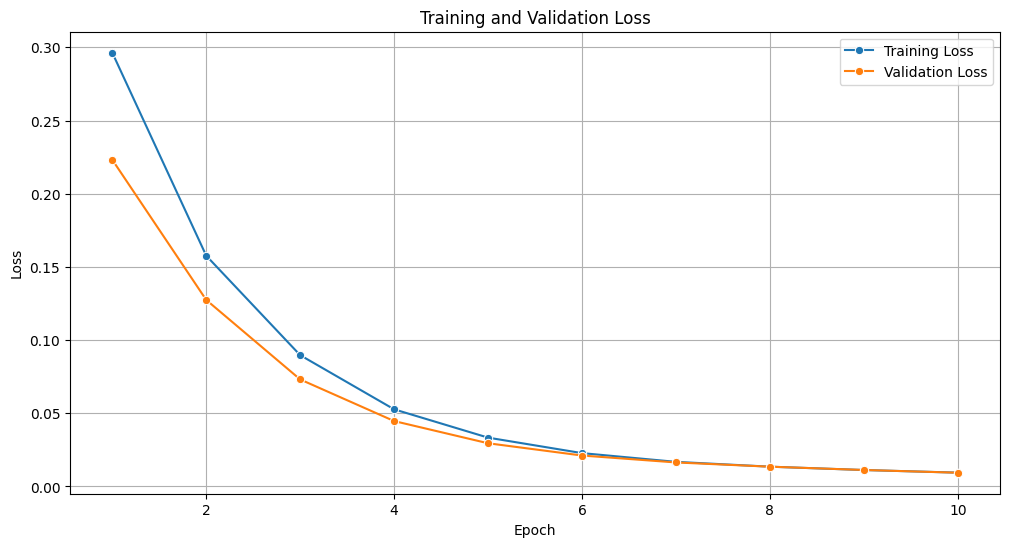

In [30]:
# plot the training and validation loss
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, executed_epochs + 1), y=train_loss_list, label='Training Loss', marker='o')
sns.lineplot(x=range(1, executed_epochs + 1), y=valid_loss_list, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

We can use the loss (average loss value? or the per-step loss value) as the $f(s_t, a_t)$ for the reward function

Also test on the testing dataset

In [32]:
criterion_raw = nn.GaussianNLLLoss(reduction='none')
criterion_sum = nn.GaussianNLLLoss(reduction='sum')


In [ ]:
avg_test_loss = 0.0
h_network.eval()  # set the model to evaluation mode
# validation loop
with torch.no_grad():

    with tqdm(test_dataloader, desc=f"Testing") as vepoch:
        for batch in vepoch:
            inputs, targets, mask = batch
            inputs, targets, mask = inputs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE)
            mean = h_network(inputs)

            # flatten the mean and targets to apply mask
            mean = mean.view(-1)
            targets = targets.view(-1)
            mask = mask.view(-1)

            mean_masked = torch.masked_select(mean, mask)  # apply mask to the mean
            targets_masked = torch.masked_select(targets, mask)  # apply mask to the targets

            loss_mean = criterion(mean_masked, targets_masked, var=torch.ones_like(mean_masked))  # assuming unit variance for simplicity
            loss_sum = criterion_sum(mean_masked, targets_masked, var=torch.ones_like(mean_masked))
            loss_raw = criterion_raw(mean_masked, targets_masked, var=torch.ones_like(mean_masked))

            print_log(f"Loss Mean: {loss_mean.item()}, Loss Sum: {loss_sum}, Loss Raw: {loss_raw}")
            print_log(f"inputs shape: {inputs.shape}, targets shape: {targets.shape}, loss mean shape: {loss_mean.shape}, loss sum shape: {loss_sum.shape}, loss raw shape: {loss_raw.shape}")

            if DEVICE.type == 'cuda':
                loss_mean = loss_mean.cpu()
            avg_test_loss += loss_mean.item()

            vepoch.set_postfix(loss=loss_mean.item())

    avg_test_loss /= len(test_dataloader)


print_log(f"Avg testing Loss: {avg_test_loss:.4f}")

Testing:   6%|▌         | 8/132 [00:00<00:03, 39.30it/s, loss=0.000128]

[2025-07-12 01:03:46:202] Loss Mean: 0.002654316136613488, Loss Sum: 86.97663116455078, Loss Raw: tensor([8.7060e-04, 4.3137e-04, 4.0675e-05,  ..., 5.6907e-07, 5.3568e-07,
        2.0895e-04], device='cuda:0')
[2025-07-12 01:03:46:202] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32768])
[2025-07-12 01:03:46:223] Loss Mean: 4.5297765609575436e-05, Loss Sum: 1.4812822341918945, Loss Raw: tensor([3.1828e-03, 3.8461e-06, 2.9622e-06,  ..., 1.5989e-05, 7.0785e-06,
        4.2746e-04], device='cuda:0')
[2025-07-12 01:03:46:223] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32701])
[2025-07-12 01:03:46:246] Loss Mean: 0.0011328617110848427, Loss Sum: 37.121612548828125, Loss Raw: tensor([9.9638e-06, 7.1390e-05, 3.5393e-06,  ..., 1.5219e-05, 1.6092e-0

Testing:  33%|███▎      | 44/132 [00:00<00:00, 134.09it/s, loss=0.015]   

[2025-07-12 01:03:46:406] Loss Mean: 0.013858398422598839, Loss Sum: 452.43511962890625, Loss Raw: tensor([1.0756e-03, 8.6075e-04, 1.1948e-03,  ..., 1.0641e-05, 2.2968e-07,
        2.2992e-04], device='cuda:0')
[2025-07-12 01:03:46:406] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32647])
[2025-07-12 01:03:46:410] Loss Mean: 0.00011643715697573498, Loss Sum: 3.801090717315674, Loss Raw: tensor([2.5482e-06, 3.9852e-08, 8.0357e-07,  ..., 5.5442e-06, 3.7702e-07,
        1.9166e-04], device='cuda:0')
[2025-07-12 01:03:46:410] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32645])
[2025-07-12 01:03:46:415] Loss Mean: 0.007125559262931347, Loss Sum: 233.49032592773438, Loss Raw: tensor([7.2106e-07, 4.2253e-06, 5.4640e-06,  ..., 2.5366e-07, 2.6981e-05

Testing:  65%|██████▌   | 86/132 [00:00<00:00, 175.24it/s, loss=0.00285] 

[2025-07-12 01:03:46:611] Loss Mean: 2.4462275177938864e-05, Loss Sum: 0.8015798330307007, Loss Raw: tensor([8.5414e-06, 3.1485e-05, 4.8763e-05,  ..., 5.7968e-06, 1.0150e-05,
        1.5090e-04], device='cuda:0')
[2025-07-12 01:03:46:611] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32768])
[2025-07-12 01:03:46:616] Loss Mean: 0.003643636591732502, Loss Sum: 119.35824584960938, Loss Raw: tensor([1.0481e-04, 1.9194e-04, 1.6966e-05,  ..., 1.2667e-05, 6.3223e-06,
        4.5568e-05], device='cuda:0')
[2025-07-12 01:03:46:617] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32758])
[2025-07-12 01:03:46:621] Loss Mean: 1.4636359082942363e-05, Loss Sum: 0.47855037450790405, Loss Raw: tensor([1.4249e-06, 3.9782e-06, 2.4771e-06,  ..., 2.2458e-07, 1.1042

Testing: 100%|██████████| 132/132 [00:00<00:00, 156.41it/s, loss=1.02e-5] 

[2025-07-12 01:03:46:817] Loss Mean: 4.0517497836844996e-05, Loss Sum: 1.3269479274749756, Loss Raw: tensor([9.8754e-06, 4.3955e-05, 1.7278e-06,  ..., 1.2362e-05, 6.5661e-07,
        5.6780e-06], device='cuda:0')
[2025-07-12 01:03:46:817] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32750])
[2025-07-12 01:03:46:823] Loss Mean: 0.022395124658942223, Loss Sum: 733.8434448242188, Loss Raw: tensor([2.0524e-07, 3.6458e-06, 2.0160e-06,  ..., 4.6867e-07, 4.8237e-05,
        7.0744e-03], device='cuda:0')
[2025-07-12 01:03:46:823] inputs shape: torch.Size([64, 512, 2]), targets shape: torch.Size([32768]), loss mean shape: torch.Size([]), loss sum shape: torch.Size([]), loss raw shape: torch.Size([32768])
[2025-07-12 01:03:46:828] Loss Mean: 7.030523556750268e-05, Loss Sum: 2.303480863571167, Loss Raw: tensor([1.4759e-05, 2.7998e-05, 3.9273e-07,  ..., 5.5603e-06, 1.5399e-05